## Part 2: Outlier Analysis and Visualisations

In [1]:
%run "../scripts/ETL.py" '../scripts/paths.json'

22/10/04 15:55:33 WARN Utils: Your hostname, mast30034 resolves to a loopback address: 127.0.1.1; using 45.113.234.45 instead (on interface eth0)
22/10/04 15:55:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 15:55:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
22/10/04 15:55:35 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.


In [2]:
pip! install lbl2vec

ERROR: unknown command "!"
Note: you may need to restart the kernel to use updated packages.


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession, functions as F
import lbl2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import folium

# Internal dataset
## Check oultiers

In [4]:
final_join3.limit(5)

22/10/04 15:56:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


merchant_name,merchant_abn,categories,take_rate,revenue_levels,name,address,state,gender,trans_merchant_abn,dollar_value,order_id,order_datetime,user_id,consumer_id,postcodes,int_sa2,SA2_code,SA2_name,income_2018-2019,total_males,total_females,total_persons,state_code,state_name,population_2020,population_2021
null,null,null,null,null,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,32234779638,39.304036732369084,02e36af7-8c70-436...,2021-11-30,18983,36103,2212,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710
Lorem Ipsum Sodal...,43186523025,florists supplies...,4.47,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,43186523025,56.35375319523918,a1d3526c-f212-41f...,2022-06-06,18983,36103,2212,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710
Pede Blandit LLP,28517327395,"books, periodical...",0.47,e,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,28517327395,276.3597685809581,b90e183b-25d4-4a6...,2022-06-14,18983,36103,2212,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710
Nullam Suscipit LLC,86388904574,"computers, comput...",4.96,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,86388904574,121.9799348513232,4c55adbf-7114-4bd...,2022-05-24,18983,36103,2212,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710
Phasellus At Limited,76767266140,"furniture, home f...",4.65,b,Lawrence Tyler,3511 Victoria Meadow,NSW,Male,76767266140,59.46778996058449,4e66a3c6-9691-44a...,2022-03-05,18983,36103,2212,119011360,119011360,Revesby,576485403,8603,9061,17664,1,New South Wales,17719,17710


In [5]:
print("Count before outlier exclusions: ", final_join3.count())

# Excluding transactions with no merchants
internal1 = final_join3.filter("merchant_abn IS NOT NULL")
print("Count after outlier exclusion 1: ", internal1.count())

# Excluding transactions with $0
internal2 = internal1.filter(internal1.dollar_value > 0)
print("Count after outlier exclusion 2: ", internal2.count())

# Excluding merchants with no transactions and record merchant name
merchants_no_trans = internal2.filter("consumer_id IS NULL")
internal3 = internal2.filter("consumer_id IS NOT NULL")
print("Count after outlier exclusion 3: ", internal3.count())


Count before outlier exclusions:  10540181


Count after outlier exclusion 1:  10109254


Count after outlier exclusion 2:  10109254


Count after outlier exclusion 3:  10109254


In [6]:
# Find null gender values and convert to undisclosed
internal4 = internal3.filter("gender IS NOT NULL")
print("Count after outlier exclusion 4: ", internal4.count())

Count after outlier exclusion 4:  10109254


No null values for gender column detected

#### From the exclusions above - it can be seen that there are only null values present in the merchant abn column
### Therefore, remove the transactions with no merchants from the final dataset.

## Visualise internal data

#### Distribution of gender amongst transactions

<AxesSubplot:xlabel='gender'>

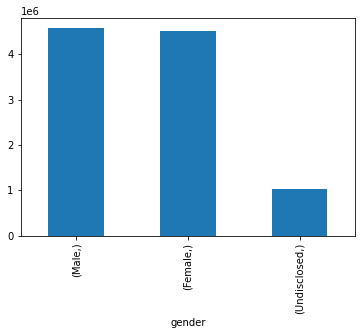

In [7]:
import matplotlib.pyplot as plt

genders = internal4.select("gender")
genderspd = genders.toPandas()
genderspd.value_counts().plot(kind='bar')

#### Distribution of genders amongst consumers

<AxesSubplot:xlabel='gender'>

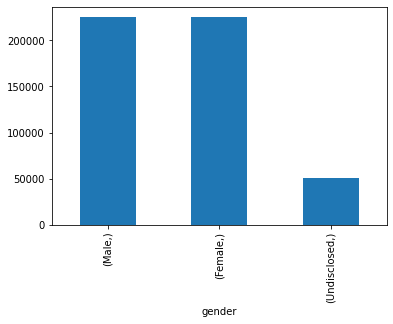

In [8]:
import matplotlib.pyplot as plt

genders = tbl_consumer.select("gender")
genderspd = genders.toPandas()
genderspd.value_counts().plot(kind='bar')

#### Distribution of total revenue for each merchant from online purchases

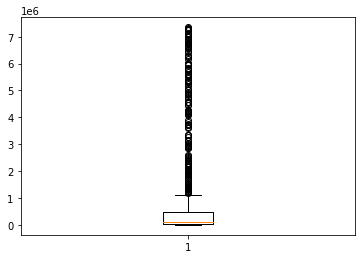

In [9]:
selected_columns = internal4.select("merchant_abn","dollar_value")
aggregated_revenue = selected_columns.groupby("merchant_abn").sum("dollar_value")
aggregated_revenue_pd = aggregated_revenue.toPandas()
total_revenue = aggregated_revenue_pd['sum(dollar_value)']

fig = plt.figure()
plt.boxplot(total_revenue)
plt.show()

#### Distributions of transactions by state

<AxesSubplot:xlabel='state'>

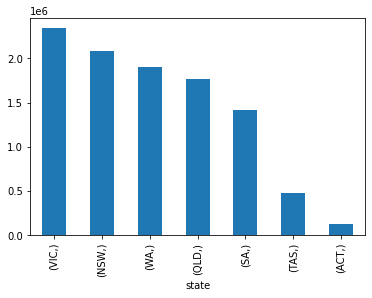

In [13]:
state = internal4.select("state")
statepd = state.toPandas()
statepd.value_counts().plot(kind='bar')

#### Number of transactions by postcode - Geospatial visualisation

In [59]:
num_transactions_by_postcode = internal4.groupBy('postcodes').count()
num_transactions_by_postcode.head()

Row(postcodes='6613', count=3377)

In [60]:
num_transactions_by_postcode.count()

2343

In [63]:
postcodes_data1 = spark.read.option("header", True).csv('../data/visualisations_postcodes.csv')
postcodes_data2 = postcodes_data1.withColumnRenamed('Postcode', 'postcodes')
postcodes_data = postcodes_data2.dropDuplicates(['postcodes'])

In [64]:
transactions_location = num_transactions_by_postcode.join(postcodes_data,['postcodes'], 'inner')
transactions_location.head()


Row(postcodes='2136', count=1687, Suburb='Burwood Heights', State='NSW', Lat='-33.890', Lon='151.100')

In [65]:
transactions_location.count()

2324

As we can see above - 19 postcodes in the transactions dataset were not found in the postcodes information dataset and hence their lattitude and longitude values were not retrieved

In [66]:
# conver transactions location to pandas df
transactions_location_pdf = transactions_location.toPandas()

aus_coords = [-25.2744, 133.7751]
m = folium.Map(aus_coords, tiles='OpenStreetMap', zoom_start=4.5)

for index, row in transactions_location_pdf.iterrows():
    if row['count'] >= 10000:
        marker_color = 'darkred'
        fill_color = 'darkred'
    elif row['count'] >= 5000:
        marker_color = 'red'
        fill_color = 'red'
    elif row['count'] >= 500:
        marker_color = 'darkorange'
        fill_color = 'darkorange'
    elif row['count'] >= 100:
        marker_color = 'orange'
        fill_color = 'orange'
    elif row['count'] <= 50 :
        marker_color = 'yellow'
        fill_color = 'yellow'
    else:
        marker_color='darkpurple'
        fill_color = 'darkpurple'
        
    folium.Circle(
          location=[row['Lat'], row['Lon']],
          popup= 'Number of transactions: ' +str(row['count']),
          tooltip=row['Suburb'],
          radius=row['count'],
          color=marker_color,
          fill=True,
          fill_color=fill_color,
       ).add_to(m)
m.save('../plots/bubble_plot_num_transactions_by_location.html')

#### Number of transactions made by month

In [14]:
date = internal4.select("order_datetime")
datepd = date.toPandas()
# convert date time to get month and year only
datepd["order_datetime"] = pd.to_datetime(datepd["order_datetime"]).dt.to_period('M')
datepd.head()

,order_datetime
0,2021-08
1,2021-08
2,2021-08
3,2021-08
4,2021-08


In [16]:
# count the number of transactions per month
datepd_groupby = datepd.groupby(['order_datetime']).size().reset_index(name='Count')
datepd_groupby.head()

,order_datetime,Count
0,2021-02,12154
1,2021-03,388963
2,2021-04,400063
3,2021-05,452938
4,2021-06,446862


<AxesSubplot:xlabel='order_datetime'>

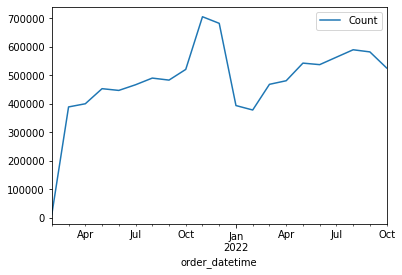

In [17]:
datepd_groupby.plot(x = "order_datetime")

# External datasets
## Check oultiers

### Census data

In [18]:
# summary statistics
census.describe()

,SA2_code,total_males,total_females,total_persons
count,2.472000e+03,2472.000000,2472.000000,2472.000000
mean,3.177555e+08,5074.887136,5209.415049,10284.254450
std,1.977886e+08,3019.275754,3161.883118,6171.395057
min,1.010210e+08,0.000000,0.000000,0.000000
25%,1.270315e+08,2669.750000,2678.000000,5384.750000
50%,3.030411e+08,4774.000000,4875.000000,9656.000000
75%,4.060111e+08,7169.000000,7511.500000,14675.000000
max,9.999995e+08,14327.000000,13783.000000,28116.000000


### Income data
Income data contains the total income for each SA2 region - not income per person

In [19]:
income.head()

,SA2_code,SA2_name,income_2018-2019
0,101021007,Braidwood,120763285
1,101021008,Karabar,338308979
2,101021009,Queanbeyan,441160946
3,101021010,Queanbeyan - East,237035656
4,101021011,Queanbeyan Region,1050285692


In [20]:
# summary statistics income_2018-2019
income['income_2018-2019'].describe()

count    2.244000e+03
mean     4.234613e+08
std      3.478390e+08
min     -7.968300e+04
25%      1.767428e+08
50%      3.324043e+08
75%      5.684244e+08
max      3.493429e+09
Name: income_2018-2019, dtype: float64

<AxesSubplot:>

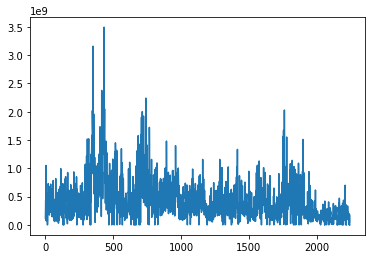

In [21]:
# income distribution
income['income_2018-2019'].astype(np.double).plot()

In [22]:
# Check which SA2 regions have negative sum of income for that region
income.loc[income['income_2018-2019'] < 0]

,SA2_code,SA2_name,income_2018-2019
278,114011275,Ettrema - Sassafras - Budawang,-79683


In [23]:
# Check if this SA2 region is in the final join
internal3.filter(internal3.SA2_code == 114011275).collect()

[]

This SA2 region with a negative total sum of income is not in the final join - so this outlier is already removed

### Population data

In [24]:
population.head()

,SA2_code,SA2_name,state_code,state_name,population_2020,population_2021
0,101021007,Braidwood,1,New South Wales,4273,4330
1,101021008,Karabar,1,New South Wales,8519,8546
2,101021009,Queanbeyan,1,New South Wales,11437,11370
3,101021010,Queanbeyan - East,1,New South Wales,5077,5093
4,101021012,Queanbeyan West - Jerrabomberra,1,New South Wales,12796,12743


In [25]:
# descriptive stats for 2020 in each SA2 region
population['population_2020'].describe()

count     2454.000000
mean     10454.477995
std       6229.349880
min          0.000000
25%       5449.500000
50%       9778.000000
75%      14832.750000
max      28250.000000
Name: population_2020, dtype: float64

In [26]:
# descriptive stats for 2021 in each SA2 region
population['population_2021'].describe()

count     2454.000000
mean     10467.839853
std       6222.168569
min          0.000000
25%       5529.750000
50%       9831.000000
75%      14911.000000
max      28573.000000
Name: population_2021, dtype: float64

# Tags 


In [33]:
merchants = tbl_merchants.toPandas()
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a


In [37]:
categories = merchants["categories"]
# Remove symbols from tag and making everything lowercase
categories = categories.str.replace('[^\w\s]', '', regex = True)
categories = categories.str.lower()
categories

0       furniture home furnishings and equipment shops...
1       cable satellite and other pay television and r...
2                jewelry watch clock and silverware shops
3                    watch clock and jewelry repair shops
4       music shops  musical instruments pianos and sh...
                              ...                        
4021               opticians optical goods and eyeglasses
4022                     books periodicals and newspapers
4023                                          shoe  shops
4024                 motor vehicle supplies and new parts
4025                 motor vehicle supplies and new parts
Name: categories, Length: 4026, dtype: object

In [38]:
merchants['cleaned_tags'] = categories

In [39]:
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...


In [41]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(merchants['cleaned_tags'])

In [42]:
categories_label = ["fashion", "furniture", "electronics", "beauty, health, personal and household", "toys, hobbies and DIY"]
len(categories_label)

5

In [54]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5,random_state=42)
LDA.fit(dtm)
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC: {categories_label[index].upper()}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC: FASHION
['new', 'motor', 'stock', 'nursery', 'flowers', 'florists', 'home', 'furnishings', 'appliances', 'manufacturers', 'shoe', 'furniture', 'equipment', 'supplies', 'shops']


THE TOP 15 WORDS FOR TOPIC: FURNITURE
['galleries', 'dealers', 'art', 'telecom', 'service', 'bicycle', 'repair', 'sales', 'artist', 'craft', 'supply', 'watch', 'clock', 'jewelry', 'shops']


THE TOP 15 WORDS FOR TOPIC: ELECTRONICS
['nurseries', 'books', 'periodicals', 'newspapers', 'beauty', 'health', 'spas', 'data', 'design', 'systems', 'processing', 'integrated', 'programming', 'computer', 'services']


THE TOP 15 WORDS FOR TOPIC: BEAUTY, HEALTH, PERSONAL AND HOUSEHOLD
['printing', 'stationery', 'writing', 'instruments', 'pianos', 'musical', 'sheet', 'tent', 'awning', 'digital', 'movies', 'books', 'shops', 'goods', 'music']


THE TOP 15 WORDS FOR TOPIC: TOYS, HOBBIES AND DIY
['television', 'radio', 'cable', 'satellite', 'pay', 'equipment', 'computer', 'software', 'peripheral', 'co

In [53]:
topic_results = LDA.transform(dtm)
merchants['store_type'] = topic_results.argmax(axis=1)
merchants.head(10)

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags,store_type,category
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"
5,Fusce Company,10206519221,"gift, card, novelty, and souvenir shops",6.34,a,gift card novelty and souvenir shops,4,Electronics
6,Aliquam Enim Incorporated,10255988167,"computers, comPUter peripheral equipment, and ...",4.32,b,computers computer peripheral equipment and so...,4,Electronics
7,Ipsum Primis Ltd,10264435225,"watch, clock, and jewelry repair shops",2.39,c,watch clock and jewelry repair shops,1,Toys and DIY
8,Pede Ultrices Industries,10279061213,"computer programming , data processing, and in...",5.71,a,computer programming data processing and inte...,2,"Beauty, Health, Personal and Household"
9,Nunc Inc.,10323485998,"furniture, home furnishings and equipment shop...",6.61,a,furniture home furnishings and equipment shops...,0,Furniture


In [48]:
myDict = {0 : 'Furniture' , 1 : 'Toys and DIY', 2 : 'Beauty, Health, Personal and Household', 3 : 'Books, Stationary and Music', 4 : 'Electronics' }
 
merchants['category'] = merchants['store_type'].map(myDict)

In [50]:
merchants.head()

,merchant_name,merchant_abn,categories,take_rate,revenue_levels,cleaned_tags,store_type,category
0,Felis Limited,10023283211,"furniture, home furnishings and equipment shop...",0.18,e,furniture home furnishings and equipment shops...,0,Furniture
1,Arcu Ac Orci Corporation,10142254217,"cable, satellite, and otHer pay television and...",4.22,b,cable satellite and other pay television and r...,4,Electronics
2,Nunc Sed Company,10165489824,"jewelry, watch, clock, and silverware shops",4.40,b,jewelry watch clock and silverware shops,1,Toys and DIY
3,Ultricies Dignissim Lacus Foundation,10187291046,"wAtch, clock, and jewelry repair shops",3.29,b,watch clock and jewelry repair shops,1,Toys and DIY
4,Enim Condimentum PC,10192359162,"music shops - musical instruments, pianos, and...",6.33,a,music shops musical instruments pianos and sh...,3,"Books, Stationary and Music"
